# Post-Processing (General)

#### Updated: May 16, 2023

#  

Post-processing pipeline after subdirectories are OCR processed:

In [4]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns

In [5]:
rootDir = 'L:/DATA/Alouette_I/BATCH_II_Run2/'
processedDir = rootDir + '04_processed/'
resultDir = rootDir + '05_result/'
logDir = rootDir + '06_log/'

#  

#### Functions:

In [6]:
def construct_timestamp(df_in):
    
    df_in['time_quality'] = 0
    
    #To the nearest second (time quality 1)
    df_in['month_day'] = pd.to_datetime(df_in['day_of_year'], format='%j').dt.strftime('%m-%d')
    df_in['month'] = df_in['month_day'].str.split('-').str[0]
    df_in['day'] = df_in['month_day'].str.split('-').str[1]
    df_in['Timestamp'] = pd.to_datetime(df_in[['year', 'month', 'day', 'hour', 'minute', 'second']], format='%Y-%m-%d %H:%M:%S')
    df_in.loc[~df_in['Timestamp'].isnull(), 'time_quality'] = 1
    df_in_tq1 = df_in.loc[df_in['time_quality'] == 1]
    
    #To the nearest minute (time quality 2)
    df_in_not_tq1 = df_in.loc[df_in['time_quality'] != 1]
    df_in_not_tq1 = df_in_not_tq1.copy(deep=True)
    df_in_not_tq1['Timestamp'] = pd.to_datetime(df_in_not_tq1[['year', 'month', 'day', 'hour', 'minute']], format='%Y-%m-%d %H:%M:00')
    df_in_not_tq1.loc[~df_in_not_tq1['Timestamp'].isnull(), 'time_quality'] = 2
    df_in_tq2 = df_in_not_tq1.loc[df_in_not_tq1['time_quality'] == 2]
    
    #To the nearest hour (time quality 3)
    df_in_not_tq2 = df_in_not_tq1.loc[df_in_not_tq1['time_quality'] != 2]
    df_in_not_tq2 = df_in_not_tq2.copy(deep=True)
    df_in_not_tq2['Timestamp'] = pd.to_datetime(df_in_not_tq2[['year', 'month', 'day', 'hour']], format='%Y-%m-%d %H:00:00')
    df_in_not_tq2.loc[~df_in_not_tq2['Timestamp'].isnull(), 'time_quality'] = 3
    df_in_tq3 = df_in_not_tq2.loc[df_in_not_tq2['time_quality'] == 3]
    
    #To the nearest day (time quality 4)
    df_in_not_tq3 = df_in_not_tq2.loc[df_in_not_tq2['time_quality'] != 3]
    df_in_not_tq3 = df_in_not_tq3.copy(deep=True)
    df_in_not_tq3['Timestamp'] = pd.to_datetime(df_in_not_tq3[['year', 'month', 'day']], format='%Y-%m-%d 00:00:00')
    df_in_not_tq3.loc[~df_in_not_tq3['Timestamp'].isnull(), 'time_quality'] = 4
    df_in_tq4 = df_in_not_tq3.loc[df_in_not_tq3['time_quality'] == 4]
    
    df_in_not_tq4 = df_in_not_tq3.loc[df_in_not_tq3['time_quality'] != 4]
    df_in = pd.concat([df_in_tq1, df_in_tq2, df_in_tq3, df_in_tq4, df_in_not_tq4])
    
    return df_in

#  

#### Generate processed_inventory - RUN BEFORE starting OCR process step:

In [ ]:
df_inventory = pd.DataFrame()
for directory in os.listdir(processedDir):
    print(directory)
    for subdirectory in os.listdir(processedDir + directory):
        n_images = len(os.listdir(processedDir + directory + '/' + subdirectory))
        df_inventory_ = pd.DataFrame({
            'Directory': directory, 
            'Subdirectory': subdirectory,
            'images': n_images,
            'subdir_id': directory + '_' + subdirectory
        }, index=[0])
        df_inventory = pd.concat([df_inventory, df_inventory_], axis=0, ignore_index=True)

In [ ]:
print(len(df_inventory))
df_inventory.head()

In [ ]:
df_inventory.to_csv(logDir + 'image_inventory_processed.csv', index=False)

#  

#### Concatenate 'OCR pass' results - START HERE after OCR processing step:

In [7]:
df_result = pd.DataFrame()
i = 0
for file in os.listdir(resultDir):
    if 'R' in file:
        directory = file
        for file2 in os.listdir(resultDir + directory + '/'):
            if 'result_OCRpass' in file2:
                fn_parts = file2.split('_')
                subdirectory = fn_parts[2].replace('.csv', '')
                if i > 0:
                    if i % 100 == 0:
                        df_result = pd.read_csv(resultDir + 'result_total.csv')
                        print(len(df_result))
                try:
                    df_load = pd.read_csv(resultDir + directory + '/' + file2, sep=',')
                    n = len(df_load)
                except pd.errors.EmptyDataError:
                    n = 0
                df_result = pd.concat([df_result, df_load])
                i += 1
                if i % 100 == 0:
                    print('Now saving the ' + str(i) + 'th result...')
                    df_result.to_csv(resultDir + 'result_raw.csv', index=False)
df_result.to_csv(resultDir + 'result_raw.csv', index=False)

#  

#### Reduce columns:

In [8]:
df_result = pd.read_csv(resultDir + 'result_raw.csv')
print(len(df_result))
df_result.head()

25882


,fmin,max_depth,satellite_number,year,day_1,day_2,day_3,hour_1,hour_2,minute_1,...,filename,station_code,station_number,rotated_metadata,station_number_OCR,year_OCR,day_of_year_OCR,hour_OCR,minute_OCR,second_OCR
0,2.032258,1361.818182,0.0,1.0,2.0,1.0,0.0,0.0,0.0,1.0,...,39.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.556452,1361.818182,0.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,...,4.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7.295082,1361.818182,3.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,40.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.500000,1361.818182,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,5.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,100.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df_result['year_1'] = df_result['year']
df_result = df_result[['Directory', 'Subdirectory', 'filename', 'processed_image_class', 'fmin', 'max_depth', 
                       'station_number', 'station_number_1', 'station_number_2', 'year_1', 'day_1', 'day_2', 'day_3', 
                       'hour_1', 'hour_2', 'minute_1', 'minute_2', 'second_1', 'second_2', 'satellite_number', 
                       'station_number_OCR', 'year_OCR', 'day_of_year_OCR', 'hour_OCR', 'minute_OCR', 'second_OCR', 
                       'metadata_type', 'is_dot', 'func_name', 'details']] 
df_result.sample(10)

,Directory,Subdirectory,filename,processed_image_class,fmin,max_depth,station_number,station_number_1,station_number_2,year_1,...,station_number_OCR,year_OCR,day_of_year_OCR,hour_OCR,minute_OCR,second_OCR,metadata_type,is_dot,func_name,details
3466,R014207810,5137,317.png,loss,1.540323,1413.636364,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,bottom,True,NaN,NaN
24992,R014207969,1294-5A,214.png,loss,1.717742,2266.666667,18.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,metadata was interpreted to be dot type
16841,R014207839,4130-50A,280.png,num2,1.709677,2059.375000,NaN,NaN,NaN,NaN,...,50.0,61,263.0,3.0,05,53.0,NaN,NaN,NaN,NaN
17590,R014207843,3225-50A,125.png,loss,1.733871,1157.446809,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,metadata could not be read by OCR
10478,R014207829,4320-8,191.png,outlier,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,image_segmentation.segment_images_in_subdir.se...,"height: 749,width: 1298"
19853,R014207941,1804-3A,294.png,num,1.612903,1194.230769,NaN,0.0,5.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8896,R014207827,3790-13A,246.png,loss,1.500000,482.978723,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,metadata could not be read by OCR
20657,R014207945,2270-5A,304.png,num,1.500000,2196.000000,NaN,5.0,0.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10475,R014207829,4320-8,158.png,outlier,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,image_segmentation.segment_images_in_subdir.se...,"height: 748,width: 1316"
5538,R014207818,4212-69-2,142.png,loss,1.560484,1900.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,metadata could not be read by OCR


#  

#### Split results into different metadata types (dot, num, num2):

In [10]:
df_result['processed_image_class'].unique()

array(['num', 'loss', 'outlier', 'num2', 'dot'], dtype=object)

In [11]:
df_num2 = df_result.loc[df_result['processed_image_class'] == 'num2']
print(len(df_num2))

4167


In [12]:
df_num = df_result.loc[df_result['processed_image_class'] == 'num']
print(len(df_num))

5605


In [13]:
df_dot = df_result.loc[df_result['processed_image_class'] == 'dot']
print(len(df_dot))

589


In [14]:
df_outlier = df_result.loc[df_result['processed_image_class'] == 'outlier']
print(len(df_outlier))

2454


In [15]:
df_loss = df_result.loc[df_result['processed_image_class'] == 'loss']
print(len(df_loss))

13067


In [16]:
len(df_num2) + len(df_num) + len(df_dot) + len(df_outlier) + len(df_loss)

25882

#### num2 - check timestamp components, construct timestamp:

In [17]:
df_num2[['year_OCR', 'day_of_year_OCR', 'hour_OCR', 'minute_OCR', 'second_OCR']].sample(10)

,year_OCR,day_of_year_OCR,hour_OCR,minute_OCR,second_OCR
6459,67.0,245,18,37,33.0
11687,67,052,23,09,15
13405,68.0,097,15,16,23
15193,81.0,135,11,16,19
5552,67,213.0,3.0,39.0,25
14142,67.0,123.0,19.0,50.0,11.0
15397,67.0,134,21,38,15
1268,68,182,09,35,15
12197,68.0,55.0,15,34,15
2275,68.0,290.0,13,57,02


year:

<Axes: xlabel='year_OCR', ylabel='Count'>

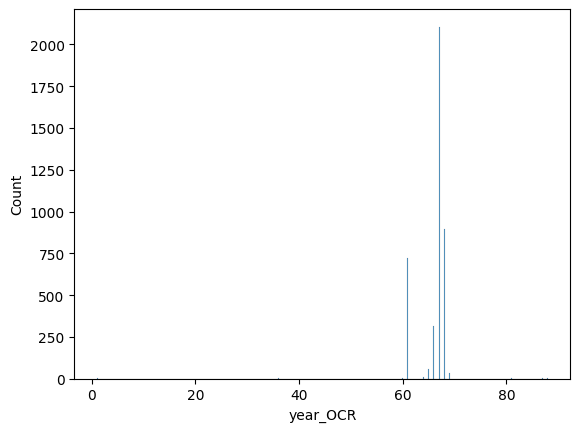

In [18]:
df_num2 = df_num2.copy(deep=True)
df_num2['year_OCR'] = df_num2['year_OCR'].astype('float')
sns.histplot(data=df_num2, x='year_OCR')

In [19]:
df_num2['year_OCR'] = df_num2['year_OCR'].apply(lambda x: np.nan if x<62 else x)
df_num2['year_OCR'] = df_num2['year_OCR'].apply(lambda x: np.nan if x>80 else x)

In [20]:
df_num2['year'] = df_num2['year_OCR'] + 1900
df_num2[['year', 'year_OCR']].sample(10)

,year,year_OCR
9917,1967.0,67.0
16378,1967.0,67.0
12915,1968.0,68.0
12235,1968.0,68.0
11690,1967.0,67.0
17060,NaN,NaN
17189,NaN,NaN
6000,1967.0,67.0
6119,1967.0,67.0
13828,1967.0,67.0


day:

<Axes: xlabel='day_of_year_OCR', ylabel='Count'>

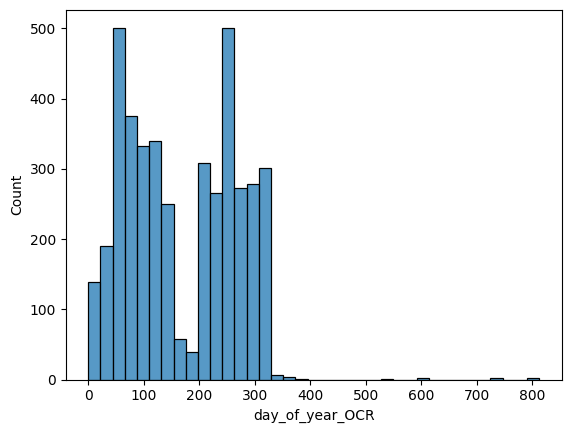

In [21]:
df_num2['day_of_year_OCR'] = df_num2['day_of_year_OCR'].astype('float')
sns.histplot(data=df_num2, x='day_of_year_OCR')

In [22]:
df_num2['day_of_year_OCR'] = df_num2['day_of_year_OCR'].apply(lambda x: np.nan if x>366 else x)
df_num2['day_of_year_OCR'] = df_num2['day_of_year_OCR'].apply(lambda x: np.nan if x==0 else x)
df_num2['day_of_year'] = df_num2['day_of_year_OCR']
df_num2[['day_of_year', 'day_of_year_OCR']].sample(10)

,day_of_year,day_of_year_OCR
10279,254.0,254.0
11371,43.0,43.0
13002,87.0,87.0
12591,105.0,105.0
5708,216.0,216.0
14317,172.0,172.0
12212,67.0,67.0
9964,16.0,16.0
15458,135.0,135.0
6399,258.0,258.0


hour:

<Axes: xlabel='hour_OCR', ylabel='Count'>

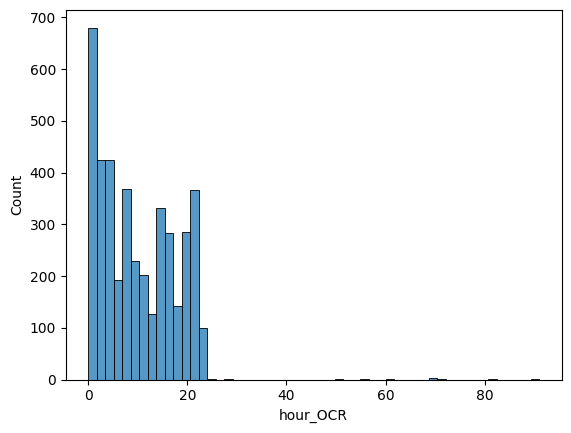

In [23]:
df_num2['hour_OCR'] = df_num2['hour_OCR'].astype('float')
sns.histplot(data=df_num2, x='hour_OCR')

In [24]:
df_num2['hour_OCR'] = df_num2['hour_OCR'].apply(lambda x: np.nan if x>24 else x)
df_num2['hour'] = df_num2['hour_OCR']
df_num2[['hour', 'hour_OCR']].sample(10)

,hour,hour_OCR
11622,8.0,8.0
14153,16.0,16.0
13614,18.0,18.0
12313,15.0,15.0
16605,8.0,8.0
14184,18.0,18.0
6723,12.0,12.0
14970,1.0,1.0
14291,2.0,2.0
11238,6.0,6.0


minute:

<Axes: xlabel='minute_OCR', ylabel='Count'>

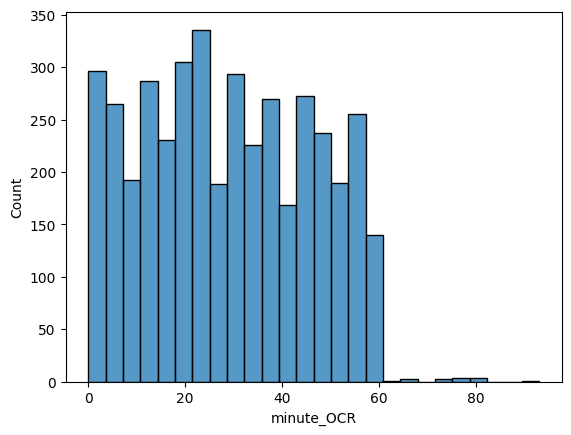

In [25]:
df_num2['minute_OCR'] = df_num2['minute_OCR'].astype('float')
sns.histplot(data=df_num2, x='minute_OCR')

In [26]:
df_num2['minute_OCR'] = df_num2['minute_OCR'].apply(lambda x: np.nan if x>60 else x)
df_num2['minute'] = df_num2['minute_OCR']
df_num2[['minute', 'minute_OCR']].sample(10)

,minute,minute_OCR
16538,31.0,31.0
11202,36.0,36.0
5526,52.0,52.0
9805,10.0,10.0
2301,51.0,51.0
5199,52.0,52.0
9214,NaN,NaN
10021,37.0,37.0
12878,5.0,5.0
16765,19.0,19.0


second:

<Axes: xlabel='second_OCR', ylabel='Count'>

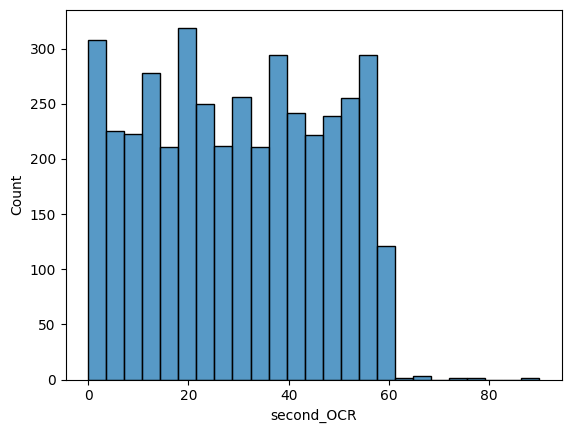

In [27]:
df_num2['second_OCR'] = df_num2['second_OCR'].astype('float')
sns.histplot(data=df_num2, x='second_OCR')

In [28]:
df_num2['second_OCR'] = df_num2['second_OCR'].apply(lambda x: np.nan if x>60 else x)
df_num2['second'] = df_num2['second_OCR']
df_num2[['second', 'second_OCR']].sample(10)

,second,second_OCR
5543,5.0,5.0
5260,29.0,29.0
18086,44.0,44.0
16468,30.0,30.0
14212,50.0,50.0
13698,18.0,18.0
6114,44.0,44.0
5661,43.0,43.0
16674,54.0,54.0
6073,35.0,35.0


construct timestamp:

In [29]:
df_num2 = construct_timestamp(df_in=df_num2)
print(len(df_num2))

4167


In [30]:
df_num2[['year', 'month', 'day', 'hour', 'minute', 'second', 'Timestamp', 'time_quality']].sample(10)

,year,month,day,hour,minute,second,Timestamp,time_quality
15381,1967.0,05,17,10.0,42.0,27.0,1967-05-17 10:42:27,1
1392,1968.0,08,04,4.0,50.0,6.0,1968-08-04 04:50:06,1
13816,1967.0,03,24,1.0,57.0,30.0,1967-03-24 01:57:30,1
17044,1967.0,11,06,23.0,29.0,18.0,1967-11-06 23:29:18,1
9797,1967.0,11,20,6.0,7.0,53.0,1967-11-20 06:07:53,1
8959,1966.0,02,09,0.0,2.0,43.0,1966-02-09 00:02:43,1
10705,1967.0,10,11,2.0,22.0,8.0,1967-10-11 02:22:08,1
16369,NaN,08,27,7.0,38.0,48.0,NaT,0
5378,NaN,04,26,0.0,0.0,22.0,NaT,0
17230,1967.0,11,05,22.0,46.0,37.0,1967-11-05 22:46:37,1


#  

#### num - check timestamp components, construct timestamp:

In [31]:
df_num[['year_1', 'day_1', 'day_2', 'day_3', 'hour_1', 'hour_2', 'minute_1', 'minute_2', 'second_1', 'second_2']].sample(10)

,year_1,day_1,day_2,day_3,hour_1,hour_2,minute_1,minute_2,second_1,second_2
21694,4.0,2.0,3.0,3.0,1.0,4.0,0.0,0.0,3.0,0.0
24467,4.0,0.0,5.0,5.0,2.0,2.0,4.0,2.0,3.0,4.0
23947,1.0,4.0,0.0,8.0,5.0,0.0,0.0,5.0,9.0,0.0
19896,4.0,2.0,1.0,3.0,1.0,0.0,2.0,0.0,3.0,7.0
22203,3.0,2.0,8.0,8.0,0.0,1.0,0.0,0.0,3.0,0.0
25142,3.0,3.0,0.0,4.0,0.0,1.0,5.0,3.0,4.0,1.0
8572,2.0,2.0,2.0,2.0,2.0,4.0,2.0,2.0,2.0,4.0
24928,3.0,2.0,1.0,2.0,0.0,2.0,0.0,3.0,3.0,7.0
8252,2.0,2.0,2.0,2.0,2.0,2.0,4.0,0.0,4.0,2.0
8044,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,4.0,2.0


year - adjust to baseline 1962:

<Axes: xlabel='year', ylabel='Count'>

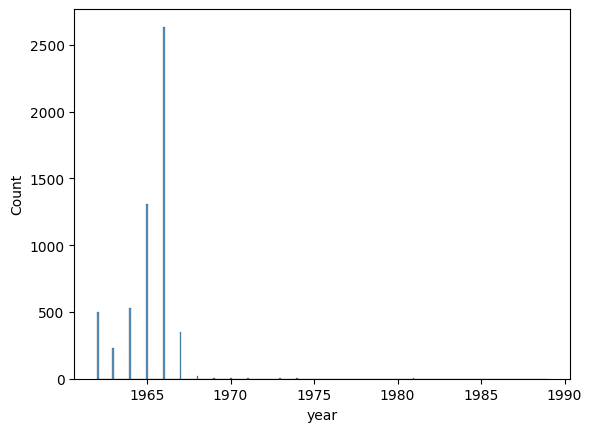

In [32]:
df_num = df_num.copy(deep=True)
df_num['year'] = df_num['year_1'] + 1962
df_num['year'] = df_num['year'].astype('float')
sns.histplot(data=df_num, x='year')

In [33]:
df_num['year'] = df_num['year'].apply(lambda x: np.nan if x<1962 else x)
df_num['year'] = df_num['year'].apply(lambda x: np.nan if x>1980 else x)
df_num[['year', 'year_1']].sample(10)

,year,year_1
20907,1967.0,5.0
8077,1964.0,2.0
20244,1964.0,2.0
24708,1965.0,3.0
20340,1964.0,2.0
25209,1965.0,3.0
8633,1964.0,2.0
23685,1966.0,4.0
23859,1966.0,4.0
22928,1965.0,3.0


day:

<Axes: xlabel='day_1', ylabel='Count'>

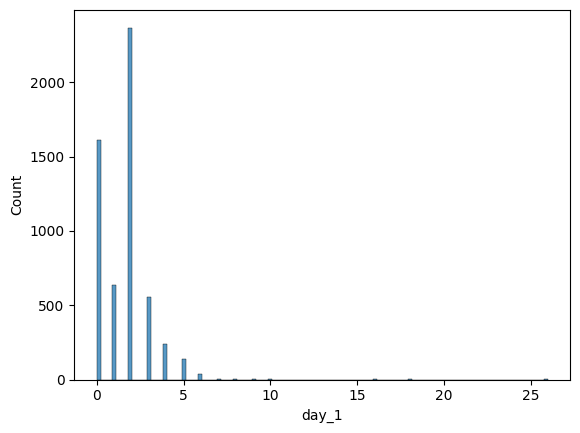

In [34]:
df_num['day_1'] = df_num['day_1'].astype(int)
sns.histplot(data=df_num, x='day_1')

In [35]:
df_num['day_1'] = df_num['day_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='day_2', ylabel='Count'>

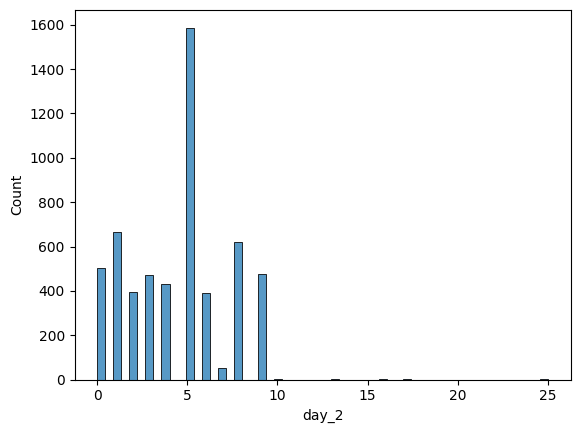

In [36]:
df_num['day_2'] = df_num['day_2'].astype(int)
sns.histplot(data=df_num, x='day_2')

In [37]:
df_num['day_2'] = df_num['day_2'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='day_3', ylabel='Count'>

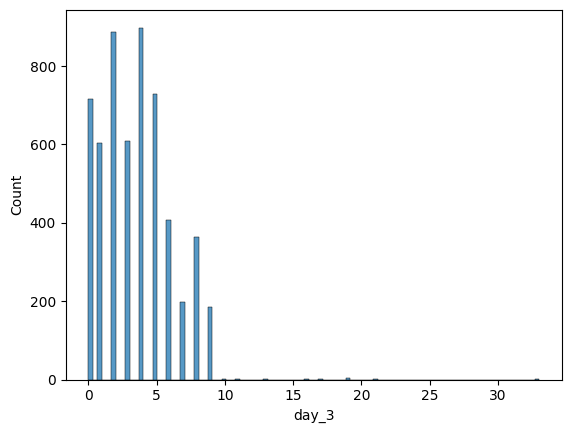

In [38]:
df_num['day_3'] = df_num['day_3'].astype(int)
sns.histplot(data=df_num, x='day_3')

In [39]:
df_num['day_3'] = df_num['day_3'].apply(lambda x: np.nan if x>9 else x)

In [40]:
df_num_daycheck = df_num[~pd.isna(df_num['day_1'])]
df_num_daycheck = df_num_daycheck[~pd.isna(df_num_daycheck['day_2'])]
df_num_daycheck = df_num_daycheck[~pd.isna(df_num_daycheck['day_3'])]
df_num_daycheck['day_of_year'] = df_num_daycheck['day_1'].astype(int).astype(str) + df_num_daycheck['day_2'].astype(int).astype(str) + df_num_daycheck['day_3'].astype(int).astype(str)
df_num_daycheck['day_of_year'] = df_num_daycheck['day_of_year'].astype(int)
df_num_daycheck['day_of_year'] = df_num_daycheck['day_of_year'].apply(lambda x: np.nan if x>366 else x)
df_num_daycheck['day_of_year'] = df_num_daycheck['day_of_year'].apply(lambda x: np.nan if x==0 else x)
df_num_nullday = df_num.loc[pd.isna(df_num['day_1']) | pd.isna(df_num['day_2']) | pd.isna(df_num['day_3'])]
df_num_nullday = df_num_nullday.copy(deep=True)
df_num_nullday['day_of_year'] = np.nan
df_num = pd.concat([df_num_daycheck, df_num_nullday])
print(len(df_num))
df_num[['day_of_year', 'day_1', 'day_2', 'day_3']].sample(10)

5605


,day_of_year,day_1,day_2,day_3
21168,252.0,2.0,5.0,2.0
19993,255.0,2.0,5.0,5.0
23024,293.0,2.0,9.0,3.0
8237,222.0,2.0,2.0,2.0
20938,NaN,4.0,9.0,0.0
24087,85.0,0.0,8.0,5.0
24077,85.0,0.0,8.0,5.0
19448,166.0,1.0,6.0,6.0
8141,223.0,2.0,2.0,3.0
23696,53.0,0.0,5.0,3.0


hour:

<Axes: xlabel='hour_1', ylabel='Count'>

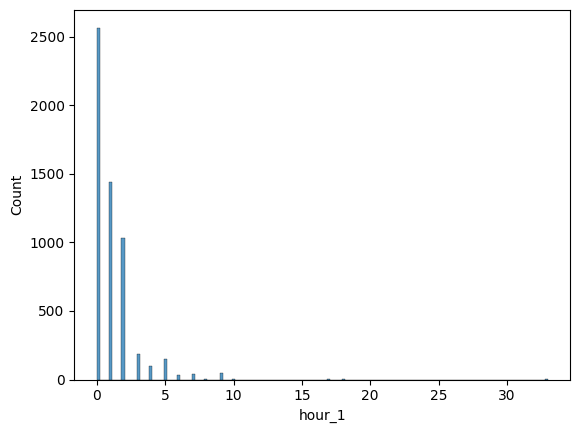

In [41]:
df_num['hour_1'] = df_num['hour_1'].astype(int)
sns.histplot(data=df_num, x='hour_1')

In [42]:
df_num['hour_1'] = df_num['hour_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='hour_2', ylabel='Count'>

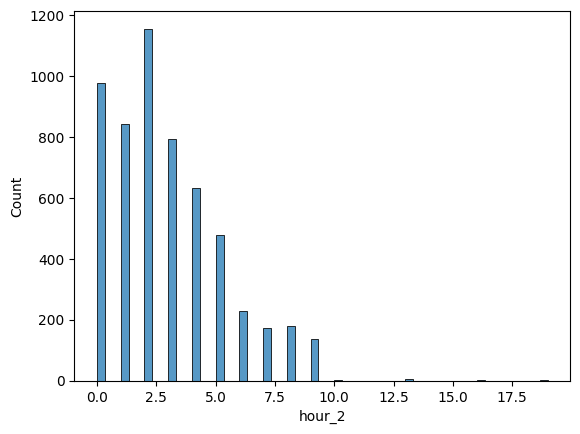

In [43]:
df_num['hour_2'] = df_num['hour_2'].astype(int)
sns.histplot(data=df_num, x='hour_2')

In [44]:
df_num['hour_2'] = df_num['hour_2'].apply(lambda x: np.nan if x>9 else x)

In [45]:
df_num_hourcheck = df_num[~pd.isna(df_num['hour_1'])]
df_num_hourcheck = df_num_hourcheck[~pd.isna(df_num_hourcheck['hour_2'])]
df_num_hourcheck['hour'] = df_num_hourcheck['hour_1'].astype(int).astype(str) + df_num_hourcheck['hour_2'].astype(int).astype(str)
df_num_hourcheck['hour'] = df_num_hourcheck['hour'].astype(int)
df_num_hourcheck['hour'] = df_num_hourcheck['hour'].apply(lambda x: np.nan if x>23 else x)
df_num_nullhour = df_num.loc[pd.isna(df_num['hour_1']) | pd.isna(df_num['hour_2'])]
df_num_nullhour = df_num_nullhour.copy(deep=True)
df_num_nullhour['hour'] = np.nan
df_num = pd.concat([df_num_hourcheck, df_num_nullhour])
print(len(df_num))
df_num[['hour', 'hour_1', 'hour_2']].sample(10)

5605


,hour,hour_1,hour_2
19019,3.0,0.0,3.0
23593,2.0,0.0,2.0
8216,22.0,2.0,2.0
25129,4.0,0.0,4.0
23010,0.0,0.0,0.0
21531,3.0,0.0,3.0
23909,NaN,4.0,2.0
21454,14.0,1.0,4.0
20584,NaN,4.0,3.0
25081,18.0,1.0,8.0


minute:

<Axes: xlabel='minute_1', ylabel='Count'>

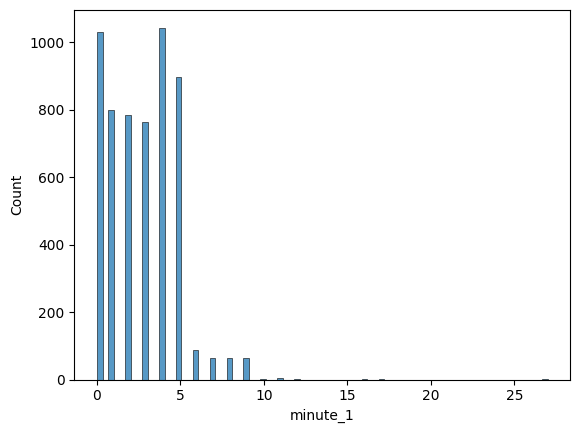

In [46]:
df_num['minute_1'] = df_num['minute_1'].astype(int)
sns.histplot(data=df_num, x='minute_1')

In [47]:
df_num['minute_1'] = df_num['minute_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='minute_2', ylabel='Count'>

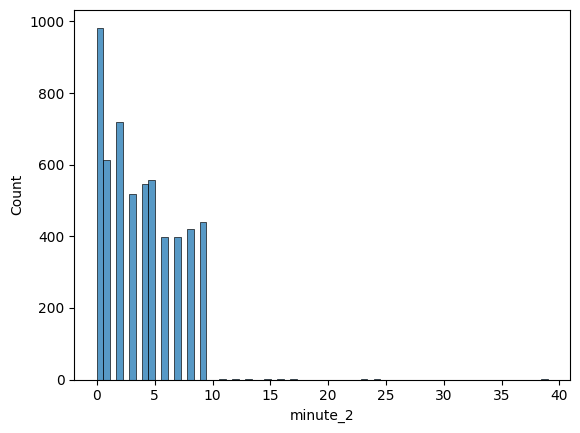

In [48]:
df_num['minute_2'] = df_num['minute_2'].astype(int)
sns.histplot(data=df_num, x='minute_2')

In [49]:
df_num['minute_2'] = df_num['minute_2'].apply(lambda x: np.nan if x>9 else x)

In [50]:
df_num_mincheck = df_num[~pd.isna(df_num['minute_1'])]
df_num_mincheck = df_num_mincheck[~pd.isna(df_num_mincheck['minute_2'])]
df_num_mincheck['minute'] = df_num_mincheck['minute_1'].astype(int).astype(str) + df_num_mincheck['minute_2'].astype(int).astype(str)
df_num_mincheck['minute'] = df_num_mincheck['minute'].astype(int)
df_num_mincheck['minute'] = df_num_mincheck['minute'].apply(lambda x: np.nan if x>59 else x)
df_num_nullmin = df_num.loc[pd.isna(df_num['minute_1']) | pd.isna(df_num['minute_2'])]
df_num_nullmin = df_num_nullmin.copy(deep=True)
df_num_nullmin['minute'] = np.nan
df_num = pd.concat([df_num_mincheck, df_num_nullmin])
print(len(df_num))
df_num[['minute', 'minute_1', 'minute_2']].sample(10)

5605


,minute,minute_1,minute_2
21258,16.0,1.0,6.0
21242,29.0,2.0,9.0
19540,17.0,1.0,7.0
22239,10.0,1.0,0.0
21660,26.0,2.0,6.0
24409,21.0,2.0,1.0
23489,44.0,4.0,4.0
8645,42.0,4.0,2.0
23018,23.0,2.0,3.0
23178,32.0,3.0,2.0


second:

<Axes: xlabel='second_1', ylabel='Count'>

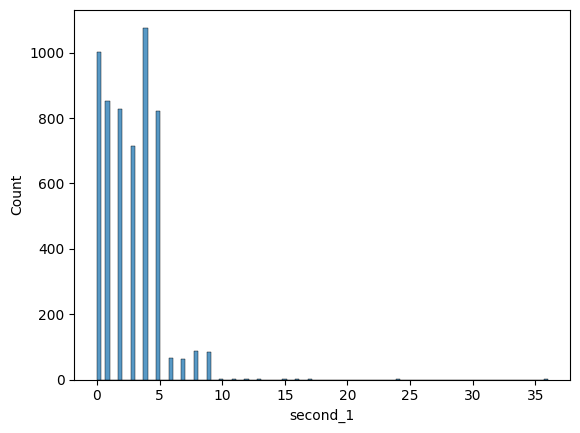

In [51]:
df_num['second_1'] = df_num['second_1'].astype(int)
sns.histplot(data=df_num, x='second_1')

In [52]:
df_num['second_1'] = df_num['second_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='second_2', ylabel='Count'>

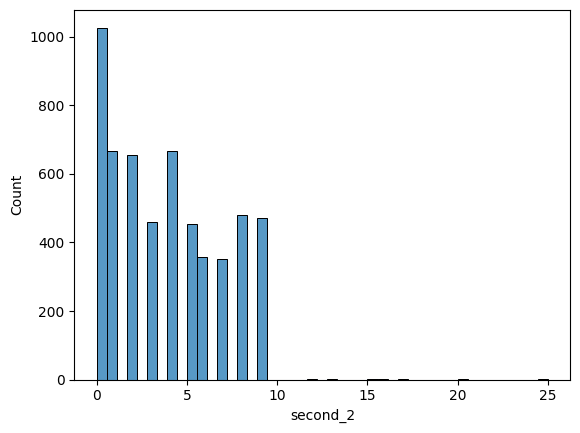

In [53]:
df_num['second_2'] = df_num['second_2'].astype(int)
sns.histplot(data=df_num, x='second_2')

In [54]:
df_num['second_2'] = df_num['second_2'].apply(lambda x: np.nan if x>9 else x)

In [55]:
df_num_seccheck = df_num[~pd.isna(df_num['second_1'])]
df_num_seccheck = df_num_seccheck[~pd.isna(df_num_seccheck['second_2'])]
df_num_seccheck['second'] = df_num_seccheck['second_1'].astype(int).astype(str) + df_num_seccheck['second_2'].astype(int).astype(str)
df_num_seccheck['second'] = df_num_seccheck['second'].astype(int)
df_num_seccheck['second'] = df_num_seccheck['second'].apply(lambda x: np.nan if x>59 else x)
df_num_nullsec = df_num.loc[pd.isna(df_num['second_1']) | pd.isna(df_num['second_2'])]
df_num_nullsec = df_num_nullsec.copy(deep=True)
df_num_nullsec['second'] = np.nan
df_num = pd.concat([df_num_seccheck, df_num_nullsec])
print(len(df_num))
df_num[['second', 'second_1', 'second_2']].sample(10)

5605


,second,second_1,second_2
22449,52.0,5.0,2.0
19839,40.0,4.0,0.0
19007,50.0,5.0,0.0
8122,42.0,4.0,2.0
23817,11.0,1.0,1.0
23525,6.0,0.0,6.0
19325,58.0,5.0,8.0
20443,NaN,7.0,0.0
20338,21.0,2.0,1.0
20370,21.0,2.0,1.0


construct timestamp:

In [56]:
df_num = construct_timestamp(df_in=df_num)
print(len(df_num))

5605


In [57]:
df_num[['year', 'month', 'day', 'hour', 'minute', 'second', 'Timestamp', 'time_quality']].sample(10)

,year,month,day,hour,minute,second,Timestamp,time_quality
23801,1966.0,02,21,20.0,52.0,14.0,1966-02-21 20:52:14,1
24547,1966.0,02,23,20.0,19.0,57.0,1966-02-23 20:19:57,1
23649,1966.0,02,22,5.0,45.0,31.0,1966-02-22 05:45:31,1
23679,1966.0,02,22,23.0,9.0,42.0,1966-02-22 23:09:42,1
20003,1966.0,09,13,17.0,37.0,11.0,1966-09-13 17:37:11,1
25090,1965.0,11,01,2.0,44.0,48.0,1965-11-01 02:44:48,1
20541,1962.0,12,17,NaN,44.0,50.0,1962-12-17 00:00:00,4
8027,1964.0,08,10,22.0,22.0,42.0,1964-08-10 22:22:42,1
65,1962.0,08,10,4.0,22.0,22.0,1962-08-10 04:22:22,1
19120,1966.0,05,20,6.0,56.0,58.0,1966-05-20 06:56:58,1


#  

#### dot - check timestamp components, construct timestamp:

In [58]:
df_dot = df_dot.copy(deep=True)
df_dot[['year_1', 'day_1', 'day_2', 'day_3', 'hour_1', 'hour_2', 'minute_1', 'minute_2', 'second_1', 'second_2', 'is_dot']].sample(10)

,year_1,day_1,day_2,day_3,hour_1,hour_2,minute_1,minute_2,second_1,second_2,is_dot
22622,NaN,1.0,16.0,8.0,8.0,8.0,9.0,0.0,1.0,1.0,NaN
22682,NaN,1.0,8.0,8.0,9.0,8.0,8.0,9.0,8.0,1.0,NaN
22559,NaN,1.0,8.0,0.0,8.0,1.0,8.0,8.0,8.0,1.0,NaN
22674,NaN,1.0,8.0,0.0,8.0,0.0,8.0,0.0,8.0,9.0,NaN
22748,NaN,1.0,16.0,8.0,8.0,9.0,16.0,0.0,24.0,9.0,NaN
21926,NaN,1.0,8.0,0.0,9.0,8.0,8.0,1.0,9.0,0.0,NaN
22732,NaN,1.0,16.0,8.0,16.0,9.0,8.0,16.0,8.0,0.0,NaN
22526,NaN,1.0,8.0,8.0,8.0,18.0,0.0,0.0,8.0,0.0,NaN
22700,NaN,1.0,8.0,8.0,0.0,9.0,9.0,0.0,17.0,0.0,NaN
22646,NaN,1.0,16.0,8.0,16.0,16.0,0.0,16.0,9.0,0.0,NaN


day:

<Axes: xlabel='day_1', ylabel='Count'>

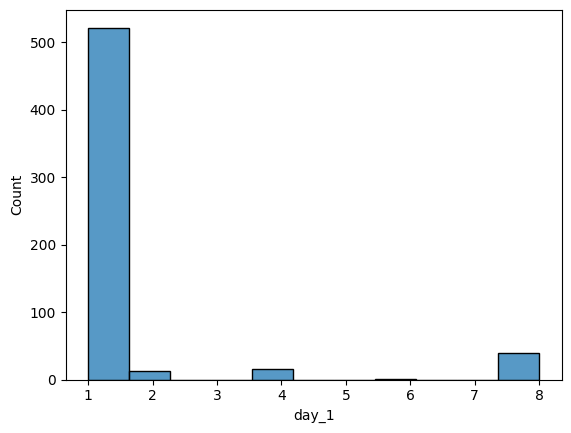

In [59]:
df_dot['day_1'] = df_dot['day_1'].astype(int)
sns.histplot(data=df_dot, x='day_1')

In [60]:
df_dot['day_1'] = df_dot['day_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='day_2', ylabel='Count'>

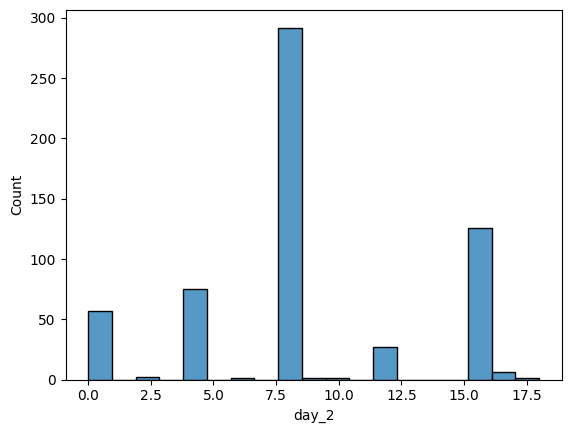

In [61]:
df_dot['day_2'] = df_dot['day_2'].astype(int)
sns.histplot(data=df_dot, x='day_2')

In [62]:
df_dot['day_2'] = df_dot['day_2'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='day_3', ylabel='Count'>

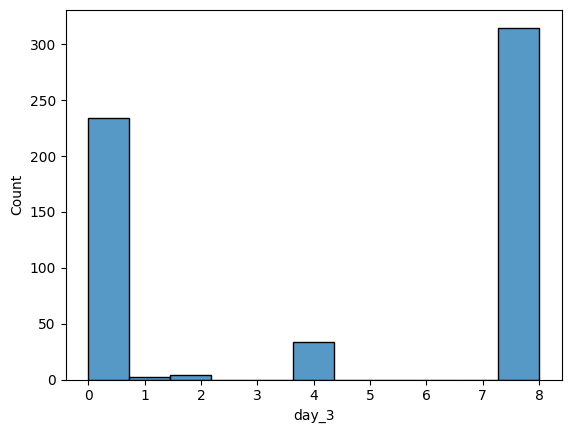

In [63]:
df_dot['day_3'] = df_dot['day_3'].astype(int)
sns.histplot(data=df_dot, x='day_3')

In [64]:
df_dot['day_3'] = df_dot['day_3'].apply(lambda x: np.nan if x>9 else x)

In [65]:
df_dot_daycheck = df_dot[~pd.isna(df_dot['day_1'])]
df_dot_daycheck = df_dot_daycheck[~pd.isna(df_dot_daycheck['day_2'])]
df_dot_daycheck = df_dot_daycheck[~pd.isna(df_dot_daycheck['day_3'])]
df_dot_daycheck['day_of_year'] = df_dot_daycheck['day_1'].astype(int).astype(str) + df_dot_daycheck['day_2'].astype(int).astype(str) + df_dot_daycheck['day_3'].astype(int).astype(str)
df_dot_daycheck['day_of_year'] = df_dot_daycheck['day_of_year'].astype(int)
df_dot_daycheck['day_of_year'] = df_dot_daycheck['day_of_year'].apply(lambda x: np.nan if x>366 else x)
df_dot_daycheck['day_of_year'] = df_dot_daycheck['day_of_year'].apply(lambda x: np.nan if x==0 else x)
df_dot_nullday = df_dot.loc[pd.isna(df_dot['day_1']) | pd.isna(df_dot['day_2']) | pd.isna(df_dot['day_3'])]
df_dot_nullday = df_dot_nullday.copy(deep=True)
df_dot_nullday['day_of_year'] = np.nan
df_dot = pd.concat([df_dot_daycheck, df_dot_nullday])
print(len(df_dot))
df_dot[['day_of_year', 'day_1', 'day_2', 'day_3']].sample(10)

589


,day_of_year,day_1,day_2,day_3
22741,180.0,1,8.0,0
21720,NaN,1,NaN,8
21824,NaN,1,NaN,8
21776,188.0,1,8.0,8
22684,180.0,1,8.0,0
22530,188.0,1,8.0,8
21786,NaN,8,0.0,0
22711,188.0,1,8.0,8
22009,NaN,1,NaN,8
22538,188.0,1,8.0,8


year - infer from day:

In [66]:
df_dot['year'] = np.nan
for i in range(0, len(df_dot)):
    day = df_dot['day_of_year'].iloc[i]
    if (day < 366) & (day > 0):
        if day > 271:
            df_dot['year'].iloc[i] = 1962
        else:
            df_dot['year'].iloc[i] = 1963
df_dot[['year', 'day_of_year', 'day_1', 'day_2', 'day_3']].sample(10)

C:\Users\rnaidoo\AppData\Local\Temp\ipykernel_21200\2722169012.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dot['year'].iloc[i] = 1963
C:\Users\rnaidoo\AppData\Local\Temp\ipykernel_21200\2722169012.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dot['year'].iloc[i] = 1962


,year,day_of_year,day_1,day_2,day_3
22765,1963.0,180.0,1,8.0,0
22729,NaN,NaN,1,NaN,8
22503,1963.0,188.0,1,8.0,8
21791,1963.0,140.0,1,4.0,0
22751,NaN,NaN,1,NaN,8
22510,1963.0,188.0,1,8.0,8
21724,NaN,NaN,1,NaN,8
21869,1963.0,180.0,1,8.0,0
22029,NaN,NaN,1,NaN,8
21968,1963.0,188.0,1,8.0,8


hour:

<Axes: xlabel='hour_1', ylabel='Count'>

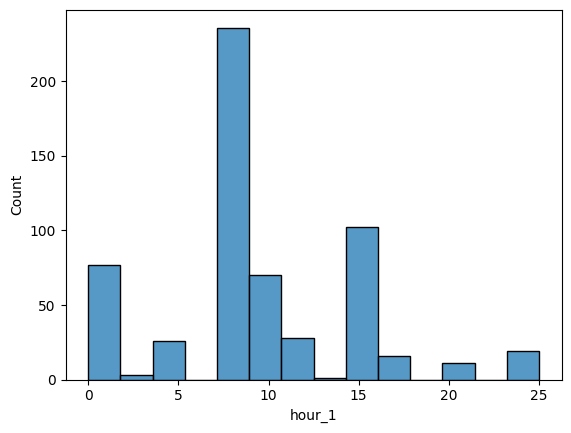

In [67]:
df_dot['hour_1'] = df_dot['hour_1'].astype(int)
sns.histplot(data=df_dot, x='hour_1')

In [68]:
df_dot['hour_1'] = df_dot['hour_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='hour_2', ylabel='Count'>

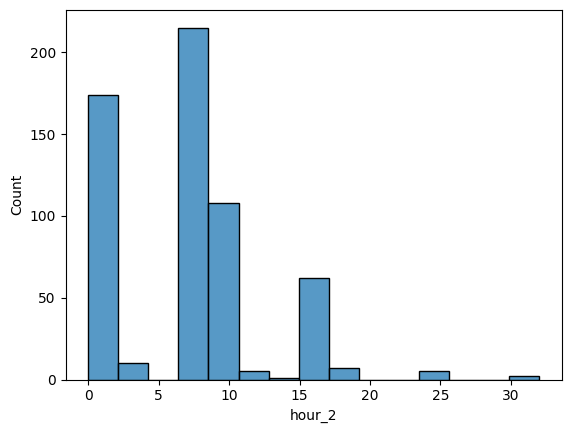

In [69]:
df_dot['hour_2'] = df_dot['hour_2'].astype(int)
sns.histplot(data=df_dot, x='hour_2')

In [70]:
df_dot['hour_2'] = df_dot['hour_2'].apply(lambda x: np.nan if x>9 else x)

In [71]:
df_dot_hourcheck = df_dot[~pd.isna(df_dot['hour_1'])]
df_dot_hourcheck = df_dot_hourcheck[~pd.isna(df_dot_hourcheck['hour_2'])]
df_dot_hourcheck['hour'] = df_dot_hourcheck['hour_1'].astype(int).astype(str) + df_dot_hourcheck['hour_2'].astype(int).astype(str)
df_dot_hourcheck['hour'] = df_dot_hourcheck['hour'].astype(int)
df_dot_hourcheck['hour'] = df_dot_hourcheck['hour'].apply(lambda x: np.nan if x>23 else x)
df_dot_nullhour = df_dot.loc[pd.isna(df_dot['hour_1']) | pd.isna(df_dot['hour_2'])]
df_dot_nullhour = df_dot_nullhour.copy(deep=True)
df_dot_nullhour['hour'] = np.nan
df_dot = pd.concat([df_dot_hourcheck, df_dot_nullhour])
print(len(df_dot))
df_dot[['hour', 'hour_1', 'hour_2']].sample(10)

589


,hour,hour_1,hour_2
22645,NaN,NaN,NaN
21833,NaN,8.0,0.0
21846,NaN,5.0,8.0
22640,NaN,8.0,8.0
22641,NaN,9.0,8.0
21842,NaN,8.0,0.0
22634,NaN,8.0,8.0
21895,NaN,9.0,8.0
22499,NaN,NaN,NaN
21830,18.0,1.0,8.0


minute:

<Axes: xlabel='minute_1', ylabel='Count'>

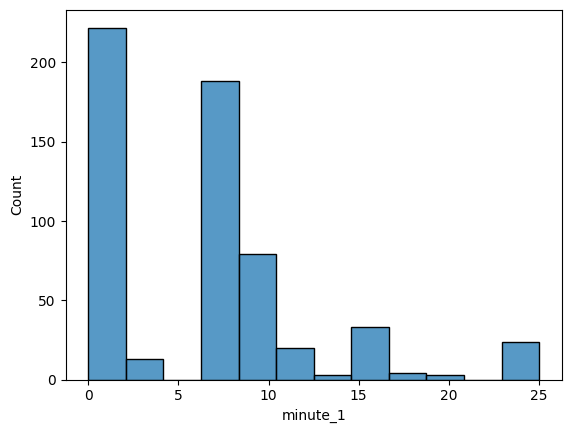

In [72]:
df_dot['minute_1'] = df_dot['minute_1'].astype(int)
sns.histplot(data=df_dot, x='minute_1')

In [73]:
df_dot['minute_1'] = df_dot['minute_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='minute_2', ylabel='Count'>

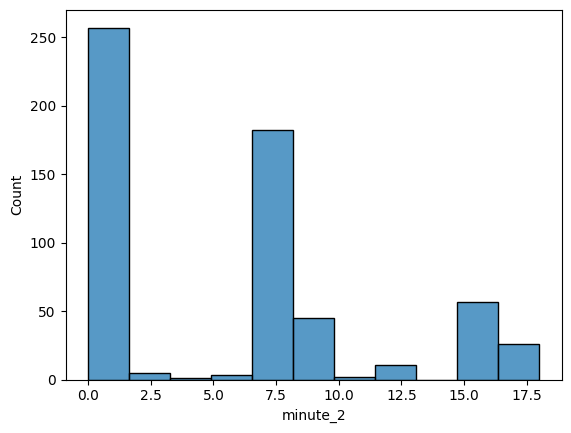

In [74]:
df_dot['minute_2'] = df_dot['minute_2'].astype(int)
sns.histplot(data=df_dot, x='minute_2')

In [75]:
df_dot['minute_2'] = df_dot['minute_2'].apply(lambda x: np.nan if x>9 else x)

In [76]:
df_dot_mincheck = df_dot[~pd.isna(df_dot['minute_1'])]
df_dot_mincheck = df_dot_mincheck[~pd.isna(df_dot_mincheck['minute_2'])]
df_dot_mincheck['minute'] = df_dot_mincheck['minute_1'].astype(int).astype(str) + df_dot_mincheck['minute_2'].astype(int).astype(str)
df_dot_mincheck['minute'] = df_dot_mincheck['minute'].astype(int)
df_dot_mincheck['minute'] = df_dot_mincheck['minute'].apply(lambda x: np.nan if x>59 else x)
df_dot_nullmin = df_dot.loc[pd.isna(df_dot['minute_1']) | pd.isna(df_dot['minute_2'])]
df_dot_nullmin = df_dot_nullmin.copy(deep=True)
df_dot_nullmin['minute'] = np.nan
df_dot = pd.concat([df_dot_mincheck, df_dot_nullmin])
print(len(df_dot))
df_dot[['minute', 'minute_1', 'minute_2']].sample(10)

589


,minute,minute_1,minute_2
22684,NaN,8.0,8.0
22676,NaN,8.0,8.0
21945,NaN,NaN,8.0
21995,NaN,NaN,0.0
21810,NaN,9.0,9.0
21949,0.0,0.0,0.0
22742,NaN,NaN,0.0
22544,9.0,0.0,9.0
22006,NaN,8.0,8.0
21878,NaN,NaN,9.0


second:

<Axes: xlabel='second_1', ylabel='Count'>

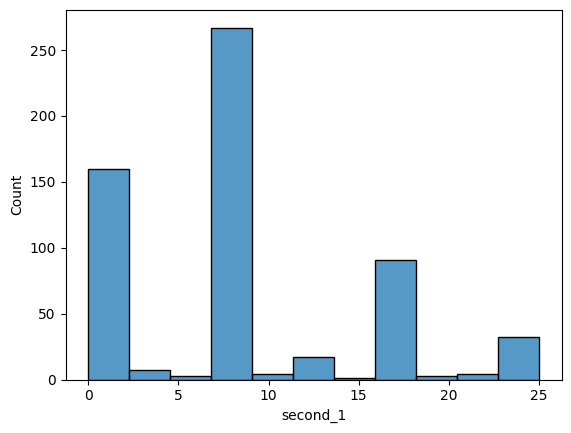

In [77]:
df_dot['second_1'] = df_dot['second_1'].astype(int)
sns.histplot(data=df_dot, x='second_1')

In [78]:
df_dot['second_1'] = df_dot['second_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='second_2', ylabel='Count'>

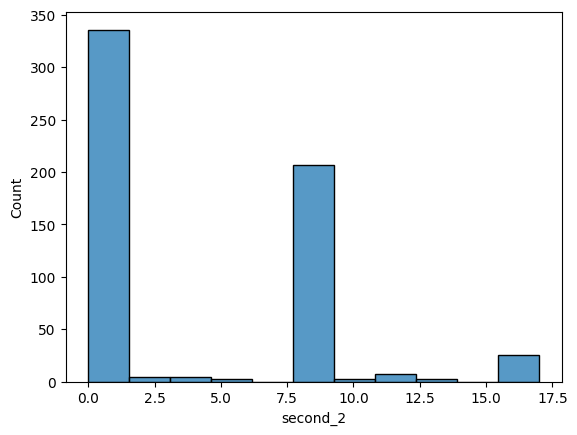

In [79]:
df_dot['second_2'] = df_dot['second_2'].astype(int)
sns.histplot(data=df_dot, x='second_2')

In [80]:
df_dot['second_2'] = df_dot['second_2'].apply(lambda x: np.nan if x>9 else x)

In [81]:
df_dot_seccheck = df_dot[~pd.isna(df_dot['second_1'])]
df_dot_seccheck = df_dot_seccheck[~pd.isna(df_dot_seccheck['second_2'])]
df_dot_seccheck['second'] = df_dot_seccheck['second_1'].astype(int).astype(str) + df_dot_seccheck['second_2'].astype(int).astype(str)
df_dot_seccheck['second'] = df_dot_seccheck['second'].astype(int)
df_dot_seccheck['second'] = df_dot_seccheck['second'].apply(lambda x: np.nan if x>59 else x)
df_dot_nullsec = df_dot.loc[pd.isna(df_dot['second_1']) | pd.isna(df_dot['second_2'])]
df_dot_nullsec = df_dot_nullsec.copy(deep=True)
df_dot_nullsec['second'] = np.nan
df_dot = pd.concat([df_dot_seccheck, df_dot_nullsec])
print(len(df_dot))
df_dot[['second', 'second_1', 'second_2']].sample(10)

589


,second,second_1,second_2
21792,NaN,NaN,0.0
22764,NaN,NaN,0.0
22025,NaN,9.0,0.0
22743,NaN,9.0,1.0
22628,NaN,9.0,8.0
22534,18.0,1.0,8.0
22632,NaN,8.0,1.0
21872,NaN,9.0,8.0
22738,NaN,NaN,8.0
21798,NaN,8.0,1.0


construct timestamp:

In [82]:
df_dot = construct_timestamp(df_in=df_dot)
print(len(df_dot))

589


In [83]:
df_dot[['year', 'month', 'day', 'hour', 'minute', 'second', 'Timestamp', 'time_quality']].sample(10)

,year,month,day,hour,minute,second,Timestamp,time_quality
21720,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0
21750,1963.0,07,07,NaN,NaN,NaN,1963-07-07 00:00:00,4
21788,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0
22567,1963.0,06,29,NaN,NaN,1.0,1963-06-29 00:00:00,4
21971,1963.0,07,07,NaN,NaN,NaN,1963-07-07 00:00:00,4
22752,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0
22556,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0
21814,1963.0,07,07,NaN,NaN,NaN,1963-07-07 00:00:00,4
22676,1963.0,06,29,8.0,NaN,NaN,1963-06-29 08:00:00,3
21789,1963.0,05,20,NaN,48.0,NaN,1963-05-20 00:00:00,4


#  

#### Check station number:

num2:

<Axes: xlabel='station_number_OCR', ylabel='Count'>

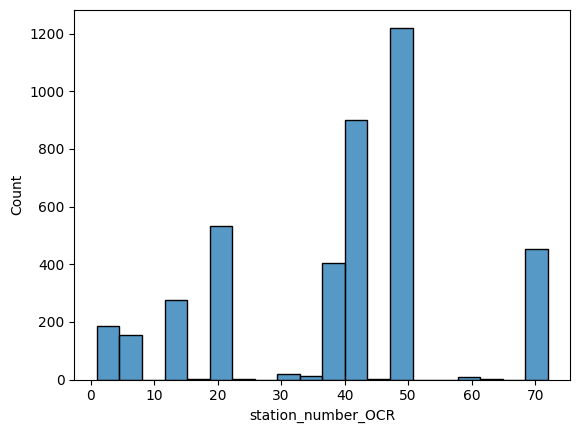

In [84]:
df_num2['station_number_OCR'] = df_num2['station_number_OCR'].astype('float')
sns.histplot(data=df_num2, x='station_number_OCR')

In [85]:
df_num2['station_number'] = df_num2['station_number_OCR']
df_num2[['station_number', 'station_number_OCR']].sample(10)

,station_number,station_number_OCR
16846,50.0,50.0
9828,21.0,21.0
16730,50.0,50.0
5771,69.0,69.0
14019,19.0,19.0
1412,37.0,37.0
12437,72.0,72.0
13816,19.0,19.0
14129,19.0,19.0
16840,50.0,50.0


num:

<Axes: xlabel='station_number_1', ylabel='Count'>

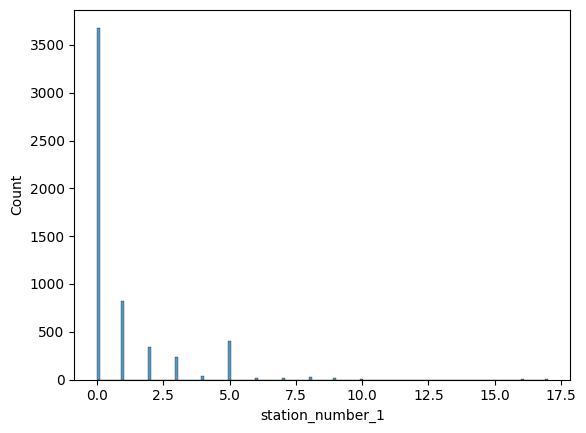

In [86]:
df_num['station_number_1'] = df_num['station_number_1'].astype(int)
sns.histplot(data=df_num, x='station_number_1')

In [87]:
df_num['station_number_1'] = df_num['station_number_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='station_number_2', ylabel='Count'>

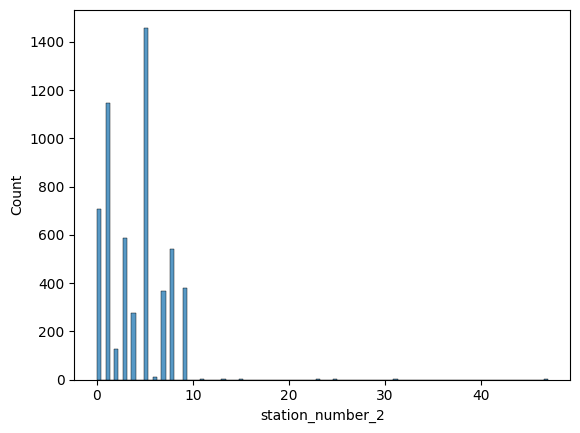

In [88]:
df_num['station_number_2'] = df_num['station_number_2'].astype(int)
sns.histplot(data=df_num, x='station_number_2')

In [89]:
df_num['station_number_2'] = df_num['station_number_2'].apply(lambda x: np.nan if x>9 else x)

In [90]:
df_num_stncheck = df_num[~pd.isna(df_num['station_number_1'])]
df_num_stncheck = df_num_stncheck[~pd.isna(df_num_stncheck['station_number_2'])]
df_num_stncheck['station_number'] = df_num_stncheck['station_number_1'].astype(int).astype(str) + df_num_stncheck['station_number_2'].astype(int).astype(str)
df_num_stncheck['station_number'] = df_num_stncheck['station_number'].astype(int)
df_num_nullstn = df_num.loc[pd.isna(df_num['station_number_1']) | pd.isna(df_num['station_number_2'])]
df_num_nullstn = df_num_nullstn.copy(deep=True)
df_num_nullstn['station_number'] = np.nan
df_num = pd.concat([df_num_stncheck, df_num_nullstn])
print(len(df_num))
df_num[['station_number', 'station_number_1', 'station_number_2']].sample(10)

5605


,station_number,station_number_1,station_number_2
22243,9.0,0.0,9.0
21393,88.0,8.0,8.0
19750,3.0,0.0,3.0
23235,1.0,0.0,1.0
24530,1.0,0.0,1.0
25203,5.0,0.0,5.0
23653,1.0,0.0,1.0
23097,7.0,0.0,7.0
22143,9.0,0.0,9.0
23386,1.0,0.0,1.0


dot:

In [91]:
df_dot[['station_number']].sample(10)

,station_number
21870,9.0
22665,8.0
22624,8.0
22728,16.0
21883,1.0
21824,1.0
22552,16.0
22015,1.0
22022,1.0
22657,32.0


#  

#### Recombine results:

In [92]:
df_result2 = pd.concat([df_num2, df_num, df_dot, df_outlier, df_loss])
print(len(df_result2))
df_result2.sample(10)

25882


,Directory,Subdirectory,filename,processed_image_class,fmin,max_depth,station_number,station_number_1,station_number_2,year_1,...,year,day_of_year,hour,minute,second,time_quality,month_day,month,day,Timestamp
2741,R014207810,5119,60.png,loss,1.697581,486.363636,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
20055,R014207944,1992-1A,224.png,num,1.645161,1525.531915,1.0,0.0,1.0,4.0,...,1966.0,256.0,21.0,8.0,56.0,1.0,09-13,09,13,1966-09-13 21:08:56
25218,R014207969,1294-5A,314.png,num,1.681452,2266.666667,5.0,0.0,5.0,3.0,...,1965.0,304.0,17.0,12.0,30.0,1.0,10-31,10,31,1965-10-31 17:12:30
14297,R014207835,4065-19A,199.png,outlier,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
18055,R014207843,3237-43A,319.png,loss,1.508065,1334.782609,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
14649,R014207836,4726-50,175.png,loss,3.009091,1520.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
8987,R014207827,3790-13A,77.png,num2,1.500000,1270.212766,3.0,NaN,NaN,NaN,...,1966.0,265.0,21.0,56.0,34.0,1.0,09-22,09,22,1966-09-22 21:56:34
16364,R014207839,4124-50A,114.png,num2,1.572581,1018.367347,50.0,NaN,NaN,NaN,...,NaN,239.0,7.0,37.0,21.0,0.0,08-27,08,27,NaT
19198,R014207941,1759-18,287.png,num,1.520161,1430.769231,18.0,1.0,8.0,4.0,...,1966.0,142.0,4.0,37.0,41.0,1.0,05-22,05,22,1966-05-22 04:37:41
12602,R014207834,4479-72,121.png,loss,1.500000,1518.750000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


#  

#### Retrieve station details:

In [93]:
df_stn_nums = pd.read_excel(logDir + 'station_number_changes.xlsx')
df_stn_nums.head()

,Station_Number,Station_Code,Station_Name,Start_Date,Notes
0,1,RES,"Resolute Bay, NT, Canada",1962-09-29,Assumed start date at launch.
1,1,BPT,"Blossom Point, MD, USA",1965-07-01,NaN
2,2,PRI,"Prince Albert, SK, Canada",1962-09-29,Assumed start date at launch.
3,3,OTT,"Ottawa, Canada",1962-09-29,Assumed start date at launch.
4,3,FTM,"Fort Myers, FL, USA",1965-07-01,NaN


In [94]:
change_dates = df_stn_nums['Start_Date'].drop_duplicates().sort_values().reset_index(drop=True)
stn_nums = df_stn_nums['Station_Number'].unique()

In [95]:
df_result3 = pd.DataFrame()
for i in range(0, len(change_dates)):
    #Before the first change date - Assume there are no station numbers before launch
    if i == 0:
        print(change_dates[i])
        df_part = df_result2.loc[df_result2['Timestamp'] < change_dates[i]]
        df_result3 = pd.concat([df_result3, df_part])
        print(len(df_result3))
    
    elif i > 0:
        print(change_dates[i])
        df_part_ = df_result2.loc[df_result2['Timestamp'] < change_dates[i]]
        df_part_ = df_part_.loc[df_part_['Timestamp'] >= change_dates[i-1]]
        
        df_sns = pd.DataFrame()
        for sn in stn_nums:
            df_sn = df_stn_nums.loc[df_stn_nums['Station_Number'] == sn]
            df_sn = df_sn.loc[df_sn['Start_Date'] < change_dates[i]]
            if len(df_sn) > 1:
                df_sn = df_sn.sort_values('Start_Date', ascending=False)
                df_sn = df_sn.iloc[:1]
            df_sns = pd.concat([df_sns, df_sn])
        
        df_part = df_part_.merge(df_sns[['Station_Number', 'Station_Code']], how='left', left_on='station_number', right_on='Station_Number')
        df_result3 = pd.concat([df_result3, df_part])
        print(len(df_result3))

#After last change date
last_change_date = change_dates[len(change_dates)-1]
print('After ' + str(last_change_date))
df_part_ = df_result2.loc[df_result2['Timestamp'] > last_change_date]

df_sns = pd.DataFrame()
for sn in stn_nums:
    df_sn = df_stn_nums.loc[df_stn_nums['Station_Number'] == sn]
    if len(df_sn) > 1:
        df_sn = df_sn.sort_values('Start_Date', ascending=False)
        df_sn = df_sn.iloc[:1]
    df_sns = pd.concat([df_sns, df_sn])

df_part = df_part_.merge(df_sns[['Station_Number', 'Station_Code']], how='left', left_on='station_number', right_on='Station_Number')
df_result3 = pd.concat([df_result3, df_part])
print(len(df_result3))

1962-09-29 00:00:00
89
1963-04-25 00:00:00
268
1963-08-06 00:00:00
637
1965-07-01 00:00:00
1086
After 1965-07-01 00:00:00
8711


In [96]:
df_stns = pd.read_csv(logDir + 'ground_stations.csv')
df_stns.head()

,Station_Code,Station_Name,Lat,Lng,Notes
0,ANT,"Antofagasta, Chile",23.6S,70.3W,NaN
1,BAT,"Byrd Station, Antarctica",80S,119.3W,Ref: https://en.wikipedia.org/wiki/Byrd_Station
2,BFR,"Bretigny, France",48.4N,2.2 E,Ref: https://en.wikipedia.org/wiki/Br%C3%A9tig...
3,BLR,"Boulder, CO, USA",40.1N,105.1W,NaN
4,BPT,"Blossom Point, MD, USA",38.4N,77.1W,NaN


In [97]:
df_result4 = df_result3.merge(df_stns[['Station_Code', 'Station_Name', 'Lat', 'Lng']], how='left', on='Station_Code')
print(len(df_result4))
df_result4[['Station_Number', 'Timestamp', 'Station_Code', 'Station_Name', 'Lat', 'Lng']].sample(10)

8711


,Station_Number,Timestamp,Station_Code,Station_Name,Lat,Lng
5889,8.0,1966-09-11 17:30:11,SNT,"Santiago, Chile",33.2S,70.1W
4415,43.0,1966-01-14 06:49:14,RES,"Resolute Bay, NT, Canada",74.7N,95W
202,NaN,1962-12-27 00:00:00,NaN,NaN,NaN,NaN
2076,13.0,1966-09-22 21:55:08,COL,"College, Fairbanks, AK, USA",64.9N,147.8W
3152,43.0,1968-01-17 15:24:52,RES,"Resolute Bay, NT, Canada",74.7N,95W
8141,13.0,1965-08-01 11:51:08,COL,"College, Fairbanks, AK, USA",64.9N,147.8W
8547,5.0,1965-11-01 02:50:24,QUI,"Quito, Ecuador",0.6S,78.6W
7639,5.0,1966-03-26 21:53:00,QUI,"Quito, Ecuador",0.6S,78.6W
6034,5.0,1966-08-22 02:06:24,QUI,"Quito, Ecuador",0.6S,78.6W
7599,5.0,1966-03-25 05:36:59,QUI,"Quito, Ecuador",0.6S,78.6W


#  

#### Save:

In [98]:
df_result5 = df_result4[['Directory', 'Subdirectory', 'filename', 'processed_image_class', 'fmin', 'max_depth', 'Timestamp',
                         'time_quality', 'Station_Number', 'Station_Code', 'Station_Name', 'Lat', 'Lng']]
df_result5.sample(10)

,Directory,Subdirectory,filename,processed_image_class,fmin,max_depth,Timestamp,time_quality,Station_Number,Station_Code,Station_Name,Lat,Lng
3477,R014207835,4065-19A,282.png,num2,1.533333,1434.042553,1967-05-04 18:35:39,1.0,19.0,ULA,"University of Alaska, Fairbanks, AK, USA",65N,147.5W
4755,R014207941,1796-5B,147.png,num,1.532258,1432.000000,1966-06-15 10:50:58,1.0,5.0,QUI,"Quito, Ecuador",0.6S,78.6W
3969,R014207839,4130-50A,155.png,num2,1.512097,1746.875000,1967-09-18 17:15:22,1.0,50.0,OTT,"Ottawa, Canada",45.4N,75.7W
4663,R014207941,1759-18,42.png,num,1.705645,1430.769231,1966-06-06 04:56:18,1.0,18.0,WOO,"Woomera, Australia",31.1S,136.8E
4325,R014207843,3225-50A,6.png,num2,1.612903,1308.510638,1966-01-24 11:24:54,1.0,50.0,OTT,"Ottawa, Canada",45.4N,75.7W
7657,R014207963,1547-5A,271.png,num,1.528226,1386.538462,1966-03-26 21:58:14,1.0,5.0,QUI,"Quito, Ecuador",0.6S,78.6W
6642,R014207961,1077-B,154.png,num,1.584677,1244.230769,1965-10-18 14:06:34,1.0,7.0,QUI,"Quito, Ecuador",0.6S,78.6W
7035,R014207963,1544-1B,199.png,num,1.500000,1292.000000,1966-02-21 01:32:46,1.0,1.0,BPT,"Blossom Point, MD, USA",38.4N,77.1W
4713,R014207941,1796-5B,104.png,num,1.520161,1340.000000,1966-06-14 13:45:24,1.0,5.0,QUI,"Quito, Ecuador",0.6S,78.6W
3297,R014207835,4060-19,233.png,num2,1.568548,1293.617021,1967-03-24 02:00:04,1.0,19.0,ULA,"University of Alaska, Fairbanks, AK, USA",65N,147.5W


In [99]:
df_result5 = df_result5.sort_values('Timestamp').reset_index(drop=True)
df_result5.to_csv(resultDir + 'result_total.csv', index=False)